<a href="https://colab.research.google.com/github/lvllvl/unet/blob/master/SegmentationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Overview

## Notes

* imgs/  -- The png image files
* masks/ -- PNG segmentation masks (update these!)
* segs/  -- The outputs in probability from our * * 
internal segnet (unreleased, too big)



###### Categories 
 * 1 - #402020 - road (all parts, anywhere nobody would look at you funny for driving)
 * 2 - #ff0000 - lane markings (don't include non lane markings like turn arrows and crosswalks)
 * 3 - #808060 - undrivable
 * 4 - #00ff66 - movable (vehicles and people/animals)
 * 5 - #cc00ff - my car (and anything inside it, including wires, mounts, etc. No reflections)



## Imports

In [1]:
from pathlib import Path
import pathlib
from PIL import  Image
import cv2
import numpy as np
from keras.utils import to_categorical
from scipy import misc
import matplotlib.pyplot as plt
from numpy import  linalg

#### Import U-Net repo

In [2]:
# ! git clone https://github.com/lvllvl/unet.git

#### import comma10k Dataset 

In [3]:
! git clone https://github.com/commaai/comma10k.git

Cloning into 'comma10k'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 27569 (delta 10), reused 46 (delta 4), pack-reused 27512
Receiving objects: 100% (27569/27569), 3.75 GiB | 14.63 MiB/s, done.
Resolving deltas: 100% (4312/4312), done.
Checking out files: 100% (11203/11203), done.


#### Set up the folders, paths 

In [4]:
path = Path.cwd()

# Comma10k data
comma10kFolder = path/'comma10k'
masksFolder = comma10kFolder/'masks' # Images with the masks ( 5574 images )
imgsFolder = comma10kFolder/'imgs' # Images with no segmentation

# Unet Path 
# you don't need this 
# unetFolder = path/'unet'


# Create directories for Train / validation datasets 
validFiles = comma10kFolder/'valid'
validFiles.mkdir( mode=511, parents= True, exist_ok = False )

trainFiles = comma10kFolder/'train'
trainFiles.mkdir( mode=511, parents=True, exist_ok=False )

# Training folder --> mask folder --> masks.png
# Training folder --> image folder --> image.png
trainMask = trainFiles/'mask'
trainMask.mkdir( mode=511, parents=True, exist_ok = False )

trainImage = trainFiles/'image'
trainImage.mkdir( mode=511, parents=True, exist_ok = False )


# Valid folder --> mask folder --> masks.png
# Valid folder --> image folder --> image.png
validMask = validFiles/'mask'
validMask.mkdir( mode=511, parents=True, exist_ok = False )

validImage = validFiles/'image'
validImage.mkdir( mode=511, parents=True, exist_ok = False )

/content/comma10k/imgs/1649_8c1cf5b2f2ec478a_2018-08-18--14-17-20_119_641.png


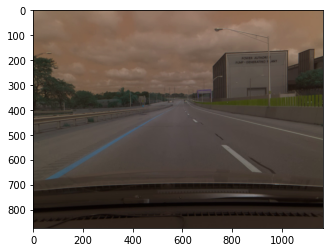

In [5]:
img = 0
for i in imgsFolder.iterdir():
  name = i.as_uri()[ 7: ]
  print( name )
  img = cv2.imread( name )
  break 
img.shape
# (874, 1164, 3)
# (874, 1164, 3)
plt.imshow( img )

/content/comma10k/masks/1649_8c1cf5b2f2ec478a_2018-08-18--14-17-20_119_641.png
mask.shape:  (874, 1164, 3)


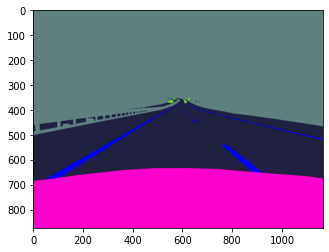

In [6]:
mask = 0 
for i in masksFolder.iterdir():
  name = i.as_uri()[ 7: ] 
  print( name ) 
  mask = cv2.imread( name ) 
  break 

print( 'mask.shape: ' , mask.shape ) 
plt.imshow( mask ) 

## Data Preparation

#### Rename files

In [7]:
fileCount = 0
prefix = 'mask_'
suffix = '.png'

for i in masksFolder.iterdir():

  file_path = i.as_uri()[ 7:31 ]
  
  name = i.as_uri()[ 31 : 35 ] 

  newName = file_path + prefix + name + suffix

  i.rename( newName ) # rename the file

  # how to evaluate a model in practice 
  # projects --> github profile, blog, working website 
  # get good at one specific thing --> e.g., computer vision 
  
  fileCount += 1 

  if fileCount % 500 == 0:
    print( 'Still processing...file count = ', fileCount )

Still processing...file count =  500
Still processing...file count =  1000
Still processing...file count =  1500
Still processing...file count =  2000
Still processing...file count =  2500
Still processing...file count =  3000
Still processing...file count =  3500
Still processing...file count =  4000
Still processing...file count =  4500
Still processing...file count =  5000
Still processing...file count =  5500


In [8]:
fileCount = 0
prefix = 'image_'
suffix = '.png'


for i in imgsFolder.iterdir():
  
  file_path = i.as_uri()[ 7:30 ]
  
  name = i.as_uri()[ 30 : 34 ] 

  newName = file_path + prefix + name + suffix

  i.rename( newName ) # rename the file
  fileCount += 1 

  if fileCount % 500 == 0:
    print( 'Still processing...file count = ', fileCount )

Still processing...file count =  500
Still processing...file count =  1000
Still processing...file count =  1500
Still processing...file count =  2000
Still processing...file count =  2500
Still processing...file count =  3000
Still processing...file count =  3500
Still processing...file count =  4000
Still processing...file count =  4500
Still processing...file count =  5000
Still processing...file count =  5500


In [9]:
for i in comma10kFolder.iterdir():
  print( i )

/content/comma10k/.gitignore
/content/comma10k/valid
/content/comma10k/tools
/content/comma10k/.git
/content/comma10k/sample.gif
/content/comma10k/requirements.txt
/content/comma10k/masks
/content/comma10k/imgs
/content/comma10k/.github
/content/comma10k/sample.jpg
/content/comma10k/train
/content/comma10k/pencil
/content/comma10k/README.md
/content/comma10k/stat.py
/content/comma10k/viewer.py
/content/comma10k/LICENSE
/content/comma10k/files_trainable
/content/comma10k/scale


In [10]:
mask = 0 
img = 0 

for i in masksFolder.iterdir():
  mask += 1
for i in imgsFolder.iterdir():
  img += 1

print( mask, img )

5574 5574


#### Split files into train / valid folders

In [11]:
# Masked Files -- Change location 

fileNames = []
count = 0

for i in masksFolder.iterdir():

  fn = i.stem + i.suffix # file name
  # print( 'fn = ', fn ) 

  if count < 4459:  # add to Train folder 
    fileNum = i.stem[ 5: ]
    fileNames.append( fileNum ) # append FileNum to fileNames array 
    
    # Now change the location 
    i.rename( Path( trainMask, fn ))

  else: # add to Valid folder
    i.rename( Path( validFiles, fn ))


  count += 1

print( 'len of fileNames: ', len( fileNames ))
c= 0
for i in trainFiles.iterdir():
  c += 1
print( c )

len of fileNames:  4459
2


In [12]:
# Now move the images from the imgsFolder 
for i in imgsFolder.iterdir():

  fn = i.stem + i.suffix # individual file name 
  
  fileNum = i.stem[ 6: ]

  if fileNum in fileNames: # change location - train folder if fileNum is in array fileNames
    i.rename( Path( trainImage, fn ))

  else: # change location  - valid folder 
    i.rename( Path( validFiles, fn ))

c = 0
for i in trainFiles.iterdir():
  c += 1 
print( c ) 

2


## Data.py

##### Imports, etc

In [13]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

# CommaAI Labels --> 5 classes
road = [ 64,	32,	32 ] 
lane_markings = [ 255, 0, 0 ] 
undriveable = [ 128, 128, 96 ] 
movable = [ 0, 255, 102 ] # vehicles, peoples, animals 
my_vehicle = [ 204,	0, 255 ]

# What does this do?
COLOR_DICT = np.array( [ road, lane_markings, undriveable, movable, my_vehicle ])

In [53]:
# Goal - replace adjustData --> create a one-hot-vector --> 
def adjustData( img, mask, flag_multi_class, num_classes ):

  if ( flag_multi_class ): # If classes > 2
    
    img = tf.cast( img, tf.float32 ) / 255.0 # TODO --> is this the right choice here?
    input_image = 0
    input_image = tf.cast( input_image, tf.float32 ) / 255.0 

    mask = mask[ :, :, 0 ] # Select 1 channel from mask
    # mask = mask / 255
    mask = tf.cast( mask, tf.float32 ) / 255.0
    mask_one_hot = to_categorical( mask, num_classes = num_classes )

    
  return ( img, mask_one_hot ) 


####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################

def train_Generator( batch_size, train_path, image_color_mode = "rgb",
                    mask_color_mode = "rgb", image_save_prefix  = "image", mask_save_prefix  = "mask",
                    flag_multi_class = True, num_class = 5, save_to_dir = None, target_size = ( 256,256 ), seed = 1 ):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    # Create Image Data Generators 
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()


    image_generator = image_datagen.flow_from_directory(
        train_path,
        target_size = target_size,
        color_mode = image_color_mode,
        class_mode = None,
        batch_size = batch_size,
        seed = seed,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix
        )
    
    # Returns:

    # A `DirectoryIterator` yielding tuples of `(x, y)`  
    #     where `x` is a numpy array containing a batch  
    #     of images with shape `(batch_size, *target_size, channels)`  
    #     and `y` is a numpy array of corresponding labels.
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        target_size = target_size,
        color_mode = mask_color_mode,
        class_mode = None,
        batch_size = batch_size,
        seed = seed,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix
        )
    
    train_generator = zip( image_generator, mask_generator )

    for img, mask in train_generator:

        img = adjustData( img, mask, flag_multi_class, num_class )
        yield (img, mask)

####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
def labelVisualize( num_class, color_dict, img ):

    img = img[ :,:,0 ] if len( img.shape ) == 3 else img

    img_out = np.zeros( img.shape + (3,) )

    for i in range( num_class ):
        img_out[ img == i,: ] = color_dict[ i ]

    return img_out / 255
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################

def saveResult( save_path, npyfile, flag_multi_class = False, num_class = 2 ):
  '''
  save_path -->
  npyfile --> 
  flag_multi_class --> bool 
  num_class --> 

  '''

  for i,item in enumerate( npyfile ):

      img = labelVisualize( num_class, COLOR_DICT, item ) if flag_multi_class else item[ :,:,0 ]

      io.imsave( os.path.join( save_path,"%d_predict.png"%i ),img )

####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################

## Create the Model

### Model.py

In [34]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import tensorflow as tf 

# (874, 1164, 3)
def unet( pretrained_weights = None, input_size = [ 256, 256, 3 ] ):
    
    # downsampling begins here 
    inputs = Input( input_size )
    conv1 = Conv2D( 64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' )( inputs )
    conv1 = Conv2D( 64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' )( conv1 )
    pool1 = MaxPooling2D( pool_size=( 2, 2 ))( conv1 )

    conv2 = Conv2D( 128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' )( pool1 )
    conv2 = Conv2D( 128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( conv2 )
    pool2 = MaxPooling2D( pool_size=( 2, 2 ))( conv2 )

    conv3 = Conv2D( 256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( pool2 )
    conv3 = Conv2D( 256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( conv3 )
    pool3 = MaxPooling2D( pool_size=(2, 2))(conv3)

    conv4 = Conv2D( 512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( pool3 )
    conv4 = Conv2D( 512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( conv4 )
    drop4 = Dropout( 0.5 )( conv4 )
    pool4 = MaxPooling2D( pool_size=( 2, 2 ))( drop4 )

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    ## upsampling begins here 
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9) 
    

    model = Model( inputs, conv10 )
    # model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    # model.compile( optimizer = Adam( lr = 1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True ),
    #               metrics = [ 'accuracy' ] )

    if (pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Execute the model 

### Main.py

In [56]:
train_dir = '/content/comma10k/train' # set directory variables
valid_dir = '/content/comma10k/valid' 


model = unet() # Declare model variable 

# Create a model check point 
model_checkpoint = ModelCheckpoint( train_dir,
                                   monitor = 'loss',
                                   verbose = 2, 
                                   save_best_only=False )


# call train_generator function 
train_xy = train_Generator( batch_size = 32, train_path = train_dir, image_color_mode='rgb',
                                  mask_color_mode='rgb', flag_multi_class=True, num_class=5, target_size = (256, 256))


model.fit( train_xy, batch_size=32, epochs=5, verbose=2,
          shuffle= True, steps_per_epoch=1 )

# results = model.predict_generator( testGene,
#                                    30,
#                                    verbose=1 )

Found 8918 images belonging to 2 classes.
Found 8918 images belonging to 2 classes.
Epoch 1/5
1/1 - 0s - loss: 2.9921e-05 - accuracy: 0.0728
Epoch 2/5
1/1 - 1s - loss: 3.1610e-05 - accuracy: 0.0564
Epoch 3/5
1/1 - 1s - loss: 3.3906e-05 - accuracy: 0.0379
Epoch 4/5
1/1 - 1s - loss: 3.3260e-05 - accuracy: 0.0547
Epoch 5/5
1/1 - 1s - loss: 3.2375e-05 - accuracy: 0.0470


NameError: ignored

## Save Model, Save Predictor

In [ ]:
model.summary() 

# Save your results HERE
saveResult( validDir,
            results )

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_48[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_49[0][0]                  
_______________________________________________________________________________________

NameError: ignored